# Quickstart

`````{margin}
````{dropdown} Necessary imports
```{code-block} python
import os
from typing import Dict, Any

import gin
import dm_env
import numpy as np
from ray import tune

from colosseum.agent.agents.episodic import QLearningEpisodic
from colosseum.analysis.plots import agent_performances_per_mdp_plot
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum import config
from colosseum.agent.actors import BaseActor
from colosseum.agent.agents.base import BaseAgent
from colosseum.agent.mdp_models.base import BaseMDPModel
from colosseum.benchmark.run import (
    instantiate_and_get_exp_instances_from_agents_and_benchmarks_for_hyperopt,
    instantiate_and_get_exp_instances_from_agents_and_benchmarks,
)
from colosseum.dynamic_programming.utils import get_policy_from_q_values
from colosseum.emission_maps import EmissionMap
from colosseum.experiment.experiment_instances import run_experiment_instances
from colosseum.hyperopt import SMALL_HYPEROPT_CONF
from colosseum.hyperopt.selection import retrieve_best_agent_config_from_hp_folder
from colosseum.hyperopt.utils import sample_agent_configs_and_benchmarks_for_hyperopt
from colosseum.utils.acme.specs import MDPSpec

seed = 42

config.set_experiments_folder("tutorial", "agent_run")
config.set_hyperopt_folder("tutorial", "agent_run")
```
````
`````

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from typing import Dict, Any

import gin
import dm_env
import numpy as np
from ray import tune

from colosseum.agent.agents.episodic import QLearningEpisodic
from colosseum.analysis.plots import agent_performances_per_mdp_plot
from colosseum.benchmark import ColosseumDefaultBenchmark
from colosseum import config
from colosseum.agent.actors import BaseActor
from colosseum.agent.agents.base import BaseAgent
from colosseum.agent.mdp_models.base import BaseMDPModel
from colosseum.benchmark.run import (
    instantiate_and_get_exp_instances_from_agents_and_benchmarks_for_hyperopt,
    instantiate_and_get_exp_instances_from_agents_and_benchmarks,
)
from colosseum.dynamic_programming.utils import get_policy_from_q_values
from colosseum.emission_maps import EmissionMap
from colosseum.experiment.experiment_instances import run_experiment_instances
from colosseum.hyperopt import SMALL_HYPEROPT_CONF
from colosseum.hyperopt.selection import retrieve_best_agent_config_from_hp_folder
from colosseum.hyperopt.utils import sample_agent_configs_and_benchmarks_for_hyperopt
from colosseum.utils.acme.specs import MDPSpec

seed = 42

config.set_experiments_folder("tutorial", "agent_run")
config.set_hyperopt_folder("tutorial", "agent_run")

The core functionality of {{col}} is to provide a principled benchmarking procedure.
The goal of this tutorial is to implement a simple q-learning agent and benchmark it.

**The agent's components**

Although new agents can be implemented from the abstract [``BaseAgent``](../pdoc_files/colosseum/agent/agents/base.html#BaseAgent) class by implementing its abstract methods,
it is possible to follow a module approach that allows to re-use components for different agents.

::::{grid}
:gutter: 3

:::{grid-item-card} [``BaseMDPModel``](../pdoc_files/colosseum/agent/mdp_models/base.html#BaseMDPModel)
stores and updates the agent's estimates, e.g. estimated transition probabilities or q-value estimates
:::

:::{grid-item-card} [``BaseActor``](../pdoc_files/colosseum/agent/actors/base.html#BaseActor)
maintains the policy for interacting with the environment. 
:::

::::

We'll implement an MDP model for the q-values `QModel` and an Actor that implements the $\epsilon$-greedy policy `QValuesActor`.
The implementation of the agent `QLearningAgent` will combine these components.

<h3> QModel </h3>

In [2]:
class QModel(BaseMDPModel):
    """ An MDP model for q-value estimates. """

    def __init__(
        self,
        seed: int,
        mdp_specs: "MDPSpec",
        alpha: float,
    ):
        """
        Parameters
        ----------
        seed : int
           the seed controlling the random parts of the model.
        mdp_specs : MDPSpec
            the specification of the MDP properties, e.g. number of states.
        alpha : float
            the coefficient for the q-learning update rule.
        """
        super(QModel, self).__init__(seed, mdp_specs)
        self._alpha = alpha
        
        # Random initialization of the q value estimates
        self.Q = self._rng.randn(self._H, self._n_states, self._n_actions).astype(np.float32)
        
        # State values initialised to the maximum reward
        self.V = np.zeros((self._H + 1, self._n_states), np.float32) + mdp_specs.rewards_range[1]

    def step_update(
        self, ts_t: dm_env.TimeStep, a_t: "ACTION_TYPE", ts_tp1: dm_env.TimeStep, h: int
    ):
        """
        updates the q value estimate using the q-learning update rule.
        
        Parameters
        ----------
        ts_t : dm_env.TimeStep
          the object containing the information at time step t.
        a_t : int
          the action the agent has taken at time step t.
        ts_tp1 : dm_env.TimeStep
          the object containing the information at time step t + 1.
        h : int
          the in-episode time step.
        """
    
        s_t = ts_t.observation
        s_tp1 = ts_tp1.observation

        # The q-learning update for all q value estimates
        self.Q[h, s_t, a_t] = self._alpha * self.Q[h, s_t, a_t] + (1 - self._alpha) * (
            ts_tp1.reward + self.V[h + 1, s_tp1]
        )
        self.V[h, s_t] = min(self._H, self.Q[h, s_t].max())

<h3> QValuesActor </h3>

In [3]:
class QValuesActor(BaseActor):
    """
    The epsilon greedy actor.
    """

    def __init__(
        self,
        seed: int,
        mdp_specs: MDPSpec,
        epsilon: float = 0.05,
    ):
        """
        Parameters
        ----------
        seed : int
            The random seed.
        mdp_specs : MDPSpec
            The full specification of the MDP.
        epsilon : float
            The probability of selecting an action at random. By default, the probability is set to 0.05.
        """
        super(QValuesActor, self).__init__(seed, mdp_specs)

        self._epsilon = epsilon
        self._n_states = self._mdp_spec.observations.num_values
        self._n_actions = self._mdp_spec.actions.num_values
        
        self._q_values = None

    def set_q_values(self, Q: np.ndarray):
        """
        updates the q-values estimates of the component with the one given in input.
        Parameters
        ----------
        Q : np.ndarray
            The q-values estimates.
        """
        self._q_values = Q
        self._episodic = Q.ndim == 3

    def select_action(self, ts: dm_env.TimeStep, time: int) -> "ACTION_TYPE":
        assert self._q_values is not None, "The q values have not been initialized."

        # Epsilon exploration
        if self._rng_fast.random() < self._epsilon:
            return self._rng_fast.randint(0, self._n_actions - 1)

        # Retrieve the q-values
        q = self._q_values[(time, ts.observation) if self._episodic else ts.observation]

        # Greedy selection
        return self._rng.choice(np.where(q == q.max())[0])

<h3> QLearningAgent </h3>

In [4]:
@gin.configurable
class QLearningAgent(BaseAgent):
    """
    The Agent class for the q-learning algorithm.
    """
    
    @staticmethod
    def is_episodic() -> bool:
        return True

    def __init__(
        self,
        # Base parameters
        seed: int,
        mdp_specs: "MDPSpec",
        optimization_horizon: int,
        # MDP model hyperparameters
        alpha: float,
        # Actor hyperparameters
        epsilon : float
    ):
        """
        Parameters
        ----------
        seed : int
            The random seed.
        mdp_specs : MDPSpec
            The specification of the MDP properties, e.g. number of states.
        optimization_horizon : int
            The total number of interactions with the MDP.
        alpha : float
            The coefficient for the q-learning update rule.
        epsilon : float
            The probability of selecting an action at random. By default, the probability is set to 0.05.
        """
        assert 0 < alpha < 1
        
        # The MDP model
        mdp_model = QModel(seed, mdp_specs, alpha)
        
        # The Actor model
        actor = QValuesActor(seed, mdp_specs, epsilon)

        super(QLearningAgent, self).__init__(
            seed, mdp_specs, mdp_model, actor, optimization_horizon
        )

    @property
    def current_optimal_stochastic_policy(self) -> np.ndarray:
        """
        Returns
        -------
        np.ndarray
            The optimal policy the agent would use if no more training was allowed.
        """
        Q_average = self._mdp_model.Q
        return get_policy_from_q_values(Q_average, True)
    
    def before_start_interacting(self):
        # Initialize the q-values in the actor
        self._actor.set_q_values(self._mdp_model.Q)
    
    def episode_end_update(self):
        """
        The Q-learning algorithm does not update anything at the end of the episode.
        """
    
    def step_update(
            self,
            ts_t: dm_env.TimeStep,
            a_t: "ACTION_TYPE",
            ts_tp1: dm_env.TimeStep,
            time: int,
        ):
        # This automatically updates the MDP model
        super(QLearningAgent, self).step_update(ts_t, a_t, ts_tp1, time)
        
        # Update the q-estimates at every time step
        self._actor.set_q_values(self._mdp_model.Q)

    @staticmethod
    def get_hyperparameters_search_spaces() -> Dict[str, tune.sample.Domain]:
        """
        Returns
        -------
            The sampling spaces associated with the hyperparameters of the algorithm.
        """
        return {
            "epsilon": tune.uniform(0.001, 0.1),
            "alpha": tune.uniform(0.001, 0.4),
        }

    @staticmethod
    def produce_gin_file_from_parameters(
        hyperparameters: Dict[str, Any], index: int = 0
    ) -> str:
        """
        Returns
        -------
          The hyperparameter values in gin file format.
        """
        string = ""
        for k, v in hyperparameters.items():
            string += f"prms_{index}/QLearningAgent.{k} = {v}\n"
        return string[:-1]

    @staticmethod
    def get_agent_instance_from_parameters(
        seed: int,
        optimization_horizon: int,
        mdp_specs: MDPSpec,
        hyperparameters: Dict[str, Any],
    ) -> "BaseAgent":
        """
        Returns
        -------
            The agent instance corresponding to the hyperparameters and the MDP specification.
            actions.
        """
        return QLearningAgent(
            mdp_specs=mdp_specs,
            seed=seed,
            optimization_horizon=optimization_horizon,
            alpha=hyperparameters["alpha"],
            epsilon=hyperparameters["epsilon"],
        )

    @staticmethod
    def is_emission_map_accepted(emission_map: "EmissionMap") -> bool:
        """
        Returns
        -------
        bool
          True if the emission map in input is the tabular one.
        """
        return emission_map.is_tabular

<h3> Benchmarking procedure </h3>

We can now proceed to perform the benchmarking procedure, which is done in two steps: the hyperparameters optimization and the benchmarking.

<h4> Hyperparameters Optimization </h4>

````{margin}
```{hint}

```
````

In [5]:
# Register the new agent class
config.register_agent_class(QLearningAgent)

# Obtain the best hyperparameters
hyperopt_agents_and_benchmarks = sample_agent_configs_and_benchmarks_for_hyperopt([QLearningAgent], SMALL_HYPEROPT_CONF)
hp_exp_instances = instantiate_and_get_exp_instances_from_agents_and_benchmarks_for_hyperopt(
    hyperopt_agents_and_benchmarks
)
run_experiment_instances(hp_exp_instances)
agents_hps = retrieve_best_agent_config_from_hp_folder()

print(agents_hps[QLearningAgent])

prms_0/QLearningAgent.epsilon = 0.0381
prms_0/QLearningAgent.alpha = 0.3803



<h4> Benchmarking </h4>

We'll benchmark the agent using the
[`EPISODIC_QUICK_TEST`](../pdoc_files/colosseum/benchmark/benchmark.html#ColosseumDefaultBenchmark.EPISODIC_QUICK_TEST) benchmark,
which is the default quick benchmark for the episodic setting, against the <a href="../pdoc_files/colosseum/agent/agents/episodic/q_learning.html#QLearningEpisodic">``QLearningEpisodic``</a> implemented in the package.

In [6]:
# Add the QLearningEpisodic agent
# When the hyperparameters of a Colosseum agent class are not specified then they are retrieved
# from the package cache
agents_hps[QLearningEpisodic] = None

# Retrieve the EPISODIC_QUICK_TEST benchmark
benchmark = ColosseumDefaultBenchmark.EPISODIC_QUICK_TEST.get_benchmark()
agents_and_benchmarks = [
    (agents_hps, benchmark)
]

# Instantiate the benchmark
benchmark = ColosseumDefaultBenchmark.EPISODIC_QUICK_TEST.get_benchmark()

# Benchmarking the agents
experiment_instances = instantiate_and_get_exp_instances_from_agents_and_benchmarks(agents_and_benchmarks)
run_experiment_instances(experiment_instances)

The results of the benchmarking procedure are stored locally and can be visualized.

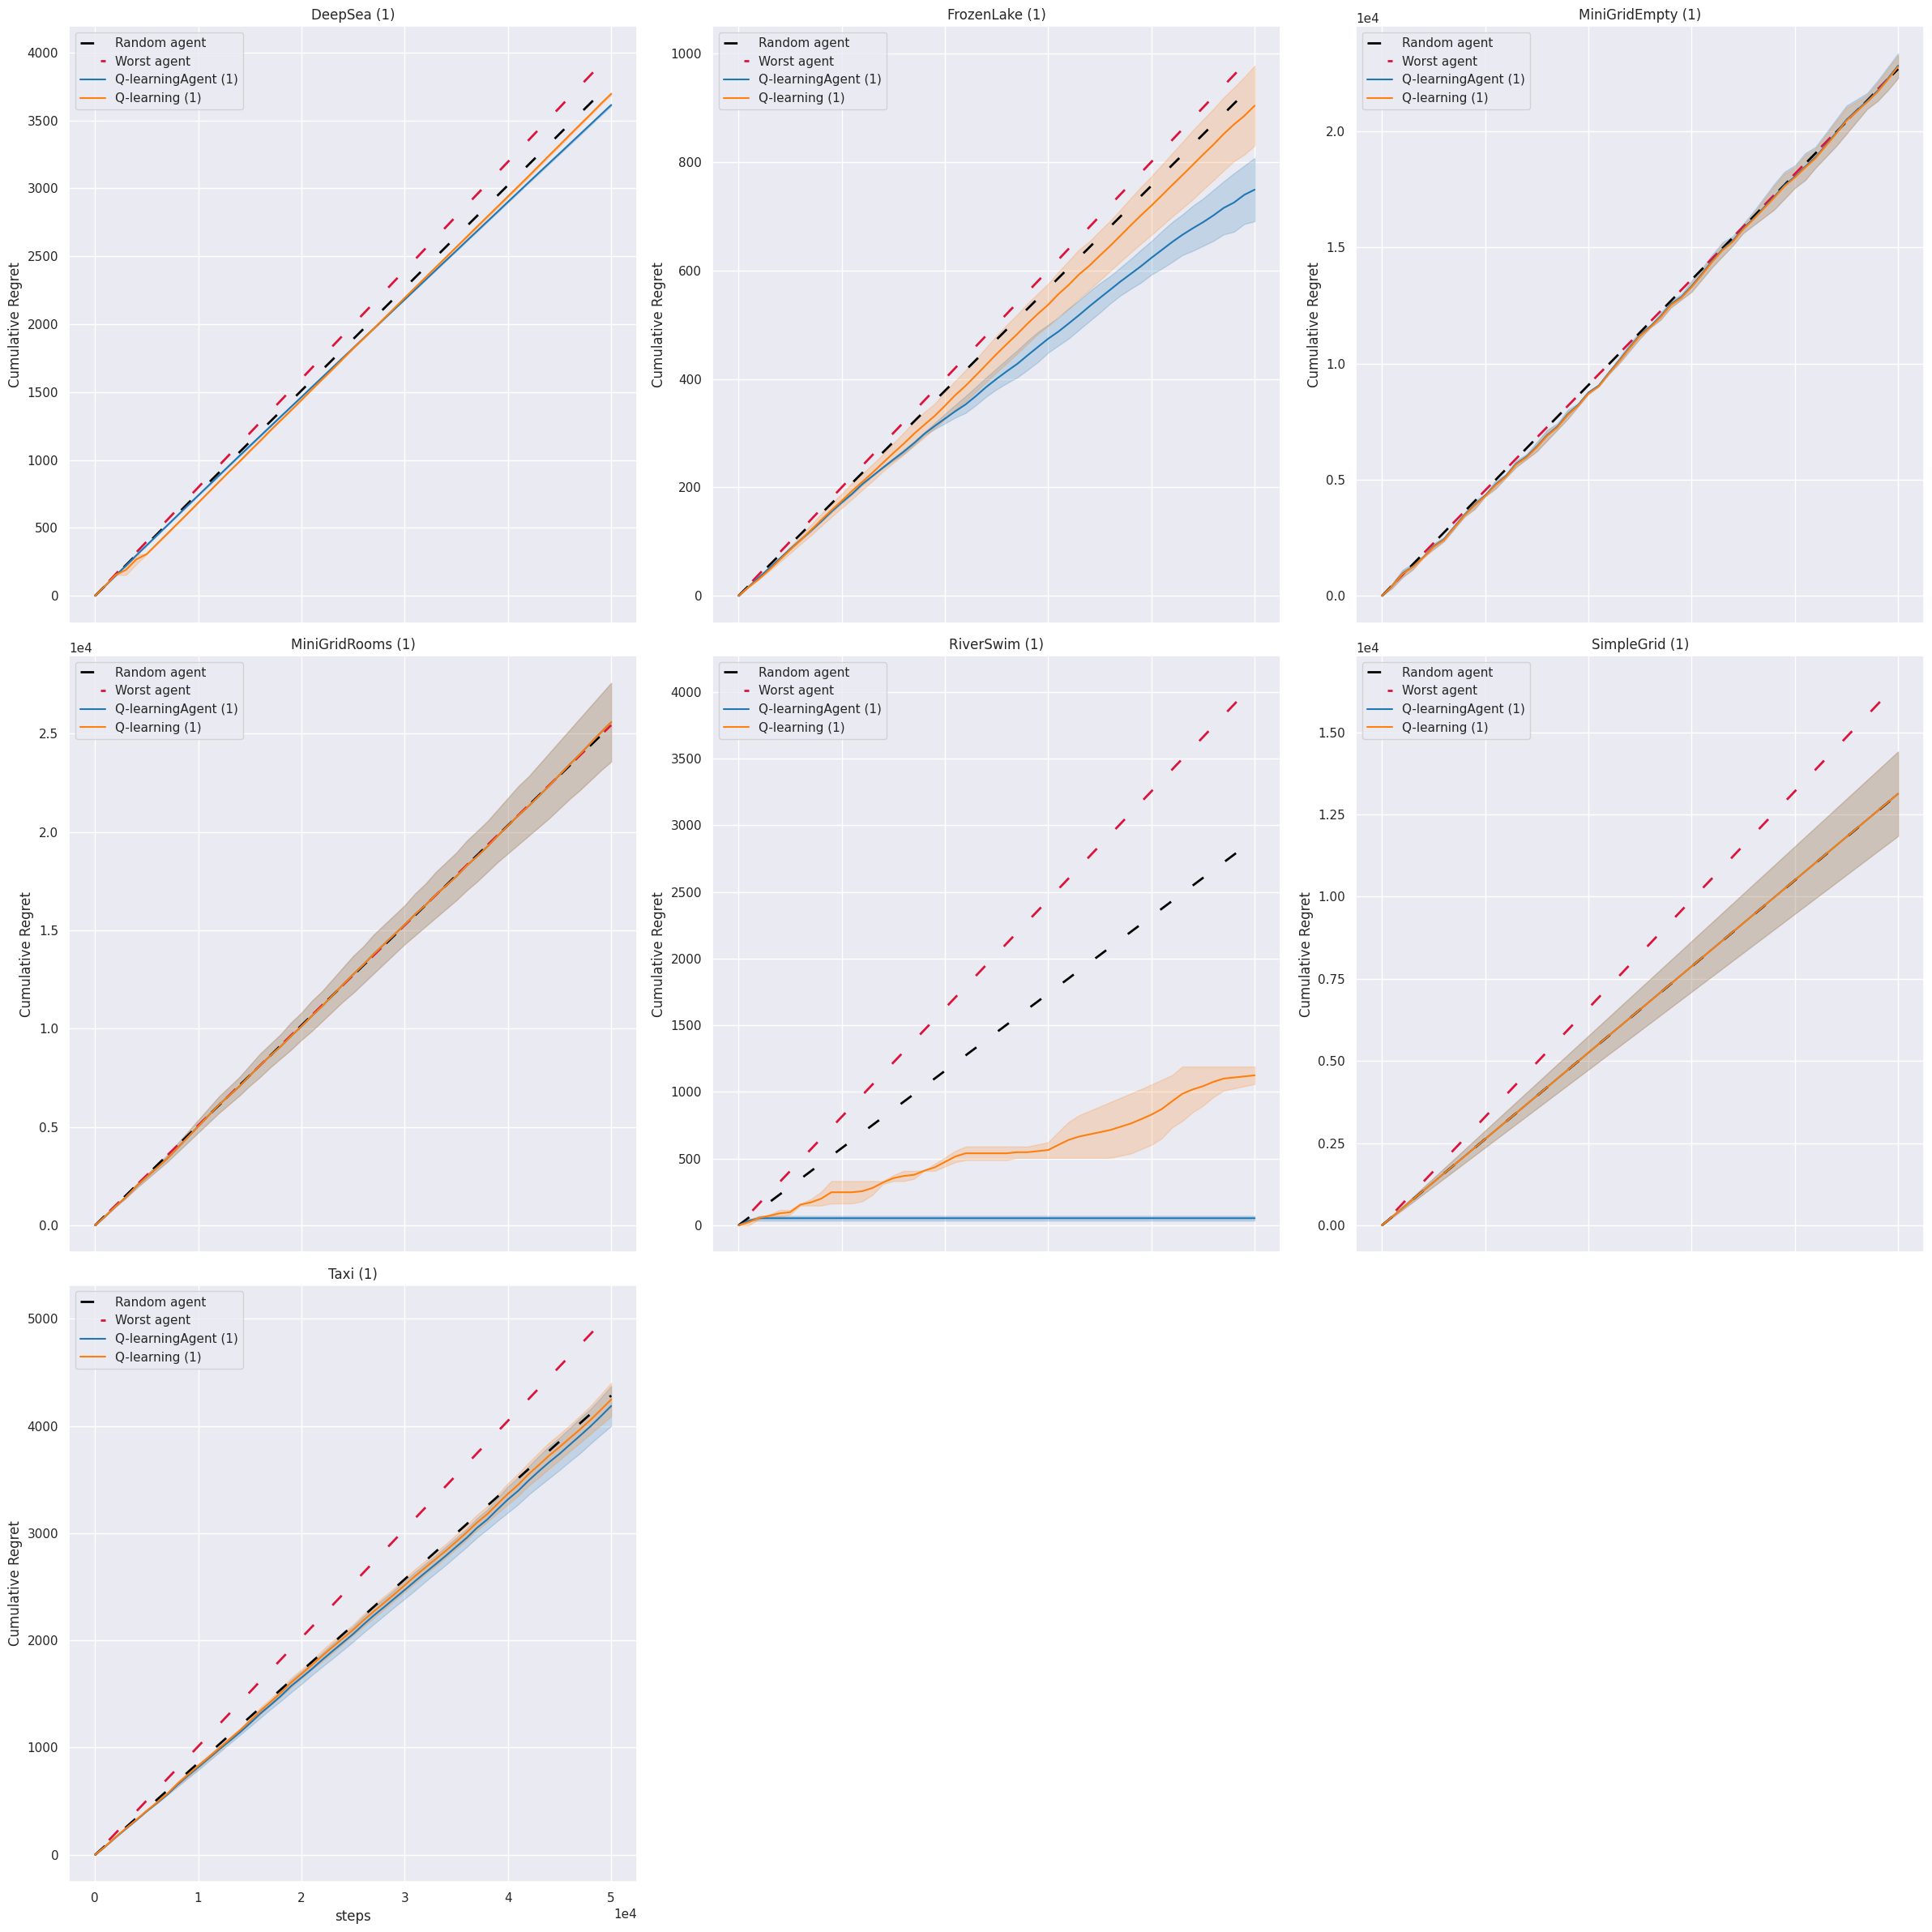

In [7]:
agent_performances_per_mdp_plot(
    benchmark.get_experiments_benchmark_log_folder(),
    "cumulative_regret"
);

In [8]:
import shutil
shutil.rmtree("tutorial")